In [1]:
import sys, os, glob, warnings, logging
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sw_plotting import change_bar_width
from sw_utilities import tukeyTest

logging.basicConfig(stream=sys.stdout, format='%(asctime)s - %(levelname)s - %(message)s', level=logging.ERROR)
# logging.basicConfig(stream=sys.stdout, format='%(asctime)s - %(levelname)s - %(message)s', level=logging.INFO)
# logging.basicConfig(stream=sys.stdout, format='%(asctime)s - %(levelname)s - %(message)s', level=logging.DEBUG)

# ignore warnings
warnings.filterwarnings('ignore')

# plotting configuration
font = {'family' : 'Arial',
        'size'   : 7}
matplotlib.rc('font', **font)
plt.rcParams['svg.fonttype'] = 'none'

# Make a folder if it is not already there to store exported figures
!mkdir ../jupyter_figures


mkdir: ../jupyter_figures: File exists


In [2]:
# Utility functions

def get_xy(info_file):
    '''
    Extract x,y positions from text file storing the ND2 metadata
    
    Input:
    ------
        Metadata text file generated using the "Show Info" function in Fiji.
        
    Output:
    -------
        A tuple storing (x, y) as a pair of float numbers.
        
    '''
    with open(info_file, 'r') as f:
        lines = f.readlines()

    for line in lines:
        if line.startswith( 'dXPos' ):
            temp = line.split('=')[-1].strip()
            x = float(temp)
        if line.startswith( 'dYPos' ):
            temp = line.split('=')[-1].strip()
            y = float(temp)
    
    return (x, y)

def get_xy_df(info_folder):
    '''
    Extract list of x,y positions from text files storing the ND2 metadata
    
    Input:
    ------
        Path to folder containing the metadata text files
        generated using the "Show Info" function in Fiji.
        
    Output:
    -------
        A pandas data frame storing annotated (x, y) positions.
    '''
    file_list = glob.glob(info_folder + os.path.sep + '*.txt')
    file_list.sort()
    
    xy_list = []
    for info_file in file_list:
        xy_list.append( get_xy(info_file) )
    
    xy_list_reshaped = list(zip(*xy_list))
    x = list( xy_list_reshaped[0] )
    y = list( xy_list_reshaped[1] )
    basename_list = [ os.path.basename(i) for i in file_list ]
    idx = list( range(1, len(basename_list)+1 ) )
    
    df = pd.DataFrame( {'file_name': basename_list,
                        'file_id': idx,
                        'x': x,
                        'y': y
                       } )
    return df


In [13]:
# Dataset info

dataset_prefix = '170902-Col4a1-TAMRA'

parent_folder = os.path.join('..', 'data', 'Fig1-ECM-mRNA-apical-polarization',
                             '_smFISH-for-polarity-quantification-curated')

# parent_folder = os.path.join('..', 'data', 'Fig1-ECM-mRNA-apical-polarization',
#                              '_smFISH-for-polarity-quantification')

image_folder = os.path.join(parent_folder, dataset_prefix)

info_folder = os.path.join(parent_folder, dataset_prefix + '-output')

In [14]:
# Extracting x,y position list from the metadata text files

df = get_xy_df(info_folder)
df.head()

,file_name,file_id,x,y
0,20170902 Col4a1 smFISH 001-info.txt,1,13322.5,-4889.7
1,20170902 Col4a1 smFISH 002-info.txt,2,13152.7,-5002.5
2,20170902 Col4a1 smFISH 003-info.txt,3,13331.6,-4998.0
3,20170902 Col4a1 smFISH 004-info.txt,4,8847.9,-2294.9
4,20170902 Col4a1 smFISH 005-info.txt,5,8790.9,-2411.9


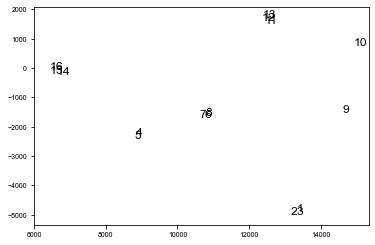

In [15]:
# Plot the coordinates to get a quick look of which images belong to the same glands

fig, ax = plt.subplots()

# plot the points
ax.scatter(df.x, df.y, alpha=0)

for i, txt in enumerate( df.file_id.tolist() ):
    ax.annotate(str(txt), (df.x[i], df.y[i]), size='xx-large')

plt.savefig( os.path.join(info_folder, dataset_prefix + '-xy-pos.png') )

In [16]:
x1, x2 = df.x[0], df.x[1]
y1, y2 = df.y[0], df.y[1]
distance = ( (x1-x2)**2 + (y1-y2)**2 ) ** .5
distance

203.85259380248218

In [17]:
# annotate cluster sizes based on the plot above
# cluster_sizes = [3, 4, 4, 2]
# cluster_sizes = [4, 4, 8, 6]
cluster_sizes = [3, 2, 3, 1, 1, 3, 3]
# cluster_sizes = [2]

# check whether annotation of cluster sizes is valid
assert sum(cluster_sizes) == len(df)


In [18]:
# Annotate the SMG id and field id using cluster sizes

SMG_id = []
field_id = []
for i in range(len(cluster_sizes)):
    for j in range(cluster_sizes[i]):
        SMG_id.append(i+1)
        field_id.append(j+1)

image_id = ['SMG '+str(SMG_id[i])+'-'+str(field_id[i]) for i in range(len(df))]
image_id

['SMG 1-1',
 'SMG 1-2',
 'SMG 1-3',
 'SMG 2-1',
 'SMG 2-2',
 'SMG 3-1',
 'SMG 3-2',
 'SMG 3-3',
 'SMG 4-1',
 'SMG 5-1',
 'SMG 6-1',
 'SMG 6-2',
 'SMG 6-3',
 'SMG 7-1',
 'SMG 7-2',
 'SMG 7-3']

In [9]:
# # Rename the image file names by prefixing with SMG id info

# image_file_name = [ i[:-9] + '.nd2' for i in df.file_name ]
# new_image_file_name = [ image_id[i] + ' ' + image_file_name[i] for i in range(len(df))]

# for i in range(len(df)):
#     old_f_name = os.path.join(image_folder, image_file_name[i])
#     new_f_name = os.path.join(image_folder, new_image_file_name[i])
#     os.rename(old_f_name, new_f_name)